# Comparison between the unfolding and the MDS method

In [1]:
import numpy as np
import unfolding
from unfolding._utils import conic, half_sphere, plane
from matplotlib import pyplot as plt

Create a test example with a flat plane

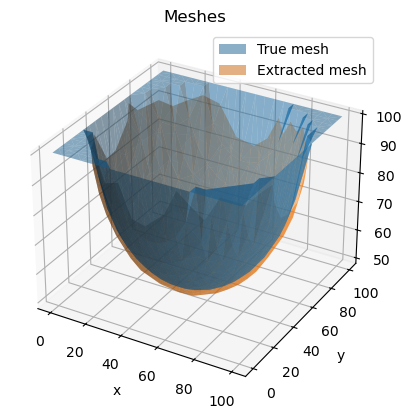

In [2]:
image, label, verts_true, faces_true = half_sphere(20)
verts, faces = unfolding.mesh_from_label((label).astype(float), initial_step_size=1, spacing=[1,1,1], num_vertices=200,method="meshlab")
ax = plt.figure().add_subplot(projection="3d")
ax.plot_trisurf(verts_true[:, 0], verts_true[:, 1], verts_true[:, 2], triangles=faces_true,alpha=0.5)
ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,alpha=0.5)
ax.set(xlabel="x",ylabel="y",zlabel="z")
plt.title("Meshes")
plt.legend(("True mesh","Extracted mesh"))

In [3]:
def show_mesh_and_layers(verts, faces, verts_2d, faces_2d, layers, k):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1,projection="3d")
    ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,alpha=0.75)
    ax1.plot_trisurf(verts_2d[:, 0], verts_2d[:, 1], 0 * verts_2d[:, 1], triangles=faces_2d,alpha=0.75)
    plt.title("Original and unfolded meshes")
    ax2 = fig.add_subplot(1,2,2,projection="rectilinear")
    ax2.imshow(layers[..., k])
    ax2.triplot(
        verts_2d[:, 1] - verts_2d[:, 1].min(),
        verts_2d[:, 0] - verts_2d[:, 0].min(),
        triangles=faces_2d,
        color="w",
    )
    plt.title("Layer")

Using unfolding

100%|██████████| 357/357 [00:51<00:00,  6.91it/s]


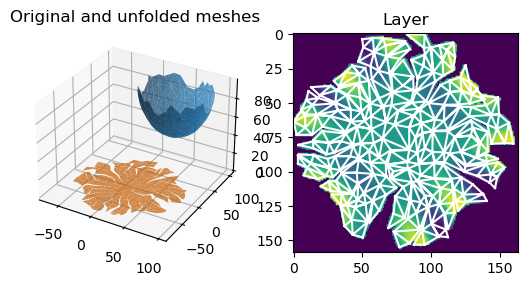

In [5]:
base_triangle = unfolding.find_center_triangle(verts, faces)
verts_2d, faces_2d, dict_2d_3d = unfolding.unfold(
    verts, faces, base_triangle=base_triangle, draw=0
)
# unfold and extract layers
layers_unfold = unfolding.unfold_layers(
    verts, faces, verts_2d, faces_2d, dict_2d_3d, image, n_layers=1
)
verts_2d = np.stack(verts_2d) # need to stack them to use trisurf
verts = np.stack(verts)
show_mesh_and_layers(verts, faces, verts_2d, faces_2d, layers_unfold, 1)


Multidimensional scaling projection

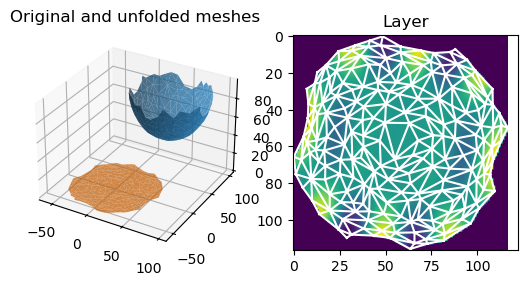

In [6]:
from sklearn.manifold import MDS

verts_2d_mds = MDS(n_components=2, metric=True).fit_transform(verts)

layers_mds = unfolding.extract_layers(verts, verts_2d_mds, faces, image, layers=np.linspace(-1,1,3))

show_mesh_and_layers(verts, faces, verts_2d_mds, faces, layers_mds, 1)


SMACOF with dissimilarity matrix

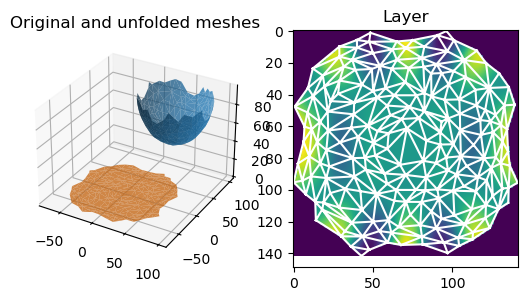

In [7]:
verts_2d_smacof = unfolding.smacof_mesh(verts, faces)
layers_smacof = unfolding.extract_layers(verts, verts_2d_smacof, faces, image, layers=np.linspace(-1,1,3))
show_mesh_and_layers(verts, faces, verts_2d_smacof, faces, layers_smacof, 1)

Isomap

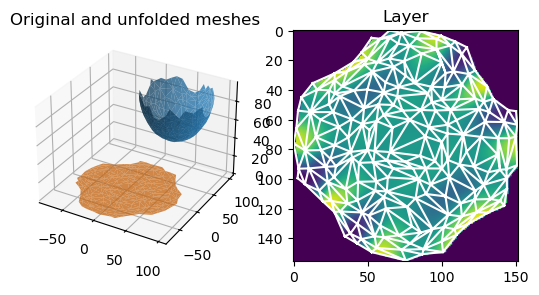

In [8]:
from sklearn.manifold import Isomap
verts_2d_iso = Isomap(n_components=2).fit_transform(verts)
layers_iso = unfolding.extract_layers(verts, verts_2d_iso, faces, image, layers=np.linspace(-1,1,3))
show_mesh_and_layers(verts, faces, verts_2d_iso, faces, layers_iso, 1)

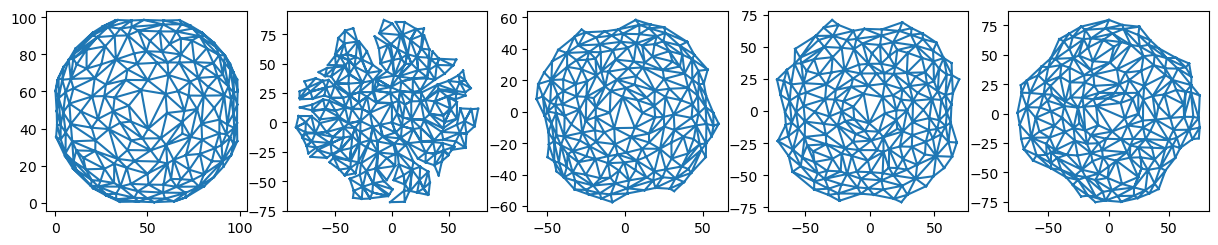

In [9]:
all = [(verts,faces),(verts_2d,faces_2d), (verts_2d_mds,faces), (verts_2d_smacof,faces),(verts_2d_iso,faces)]
fig, ax = plt.subplots(1,len(all),figsize=(15,5))
for G,a in zip(all,ax):
    a.triplot(G[0][:,1],G[0][:,0],triangles=G[1])
    a.set_box_aspect(1)